In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt

C:\Users\Hugo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SP500data = pd.read_csv('SP500_1998-2007.csv')['Close']

length_data = len(SP500data)
SP500returns = 100 * (np.array(np.log(SP500data[1:length_data]))-np.array(np.log(SP500data[0:length_data-1])))

In [3]:
#logpdf_array is an array with the loglikelihood value of every return observation given the conditional variance
#to get the total loglikelihood, this array is summed in the LLGARCH function
def logpdf_normal(theta, returns, cond_variance):
    logpdf_array = -0.5 * (np.log(2*np.pi) + np.log(cond_variance) + returns**2 / cond_variance)
    return logpdf_array

def logpdf(theta, dist, returns, cond_variance):
    if dist == 'normal':
        return logpdf_normal(theta, returns, cond_variance)

In [4]:
#you can keep the calculation of the cond variance in the LLGARCH function, but creating it's owning function for this
#may be usefull for plotting (and other uses in the future)
def calc_cond_variance(theta, dist, returns):
    omega = theta[0]
    alpha = theta[1]
    beta = theta[2]

    T = len(returns)
    cond_variance = np.zeros(T)
    cond_variance[0] = np.var(returns)

    for t in range(1, T):
        cond_variance[t] = omega + alpha * returns[t-1] **2 + beta * cond_variance[t-1]
        
    return cond_variance

In [5]:
def LLGARCH(theta, dist, returns):
    cond_variance = calc_cond_variance(theta, dist, returns)
    loglikelihood = np.sum(logpdf(theta, dist, returns, cond_variance))
    return -loglikelihood

In [6]:
def constraint(theta, dist, returns):
    #alpha + beta < 1 for stationarity, the fmin_slsqp function keeps the value in this array > 0, so alpha + beta < 1
    alpha = theta[1]
    beta = theta[2]

    return(np.array([1-alpha-beta]))

In [7]:
def estimateGARCH(dist, returns):
    omega_ini = 0.05
    alpha_ini = 0.05
    beta_ini = 0.9

    omega_bnds = (0, 1)
    alpha_bnds = (0, 1)
    beta_bnds = (0, 1)

    theta_ini = [omega_ini, alpha_ini, beta_ini]
    theta_bnds = [omega_bnds, alpha_bnds, beta_bnds]

    theta_ML = fmin_slsqp(LLGARCH, theta_ini, bounds=theta_bnds, args=(dist, returns,), f_ieqcons=constraint)

    return theta_ML

In [8]:
def GARCH(dist, returns):
    theta_ML = estimateGARCH(dist, returns)
    print(theta_ML)
    cond_variance = calc_cond_variance(theta_ML, dist, returns)
    
    plt.plot(returns, label='returns')
    plt.plot(np.sqrt(cond_variance), label='volatility')
    plt.title('returns and volatility from GARCH(1, 1)-normal model')
    plt.legend()
    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3251.21495711487
            Iterations: 15
            Function evaluations: 71
            Gradient evaluations: 15
[0.00607368 0.0672147  0.92939288]


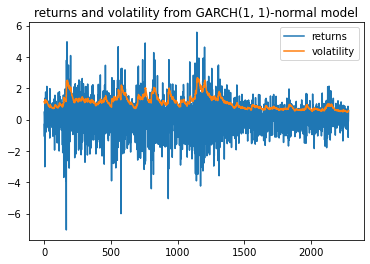

In [9]:
GARCH('normal', SP500returns)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f1a4f2a2-4ff8-4218-9ab7-a3794f539d2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>